# Introduction

## Install Dependencies
Python Kernel Version: 3.7.12

In [186]:
!pip install statsmodels tbats pmdarima fbprophet xgboost

     -------------------------------------- 125.4/125.4 MB 3.7 MB/s eta 0:00:00


## Import Libraries

In [73]:
import pandas as pd
import numpy as np

## Load & Prepare Data

In [74]:
def load_binance_pair_from_file(data_path: str) -> pd.DataFrame:
    data = pd.read_json(data_path)
    data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    data['time'] = pd.to_datetime(data['time'], unit='ms')
    data.set_index('time',inplace=True)
    
    return data.asfreq(freq='1H')

In [75]:
def load_bike_sales_from_file(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        data_path,
        index_col='dteday',
        parse_dates=True).rename(columns = {'cnt' : 'y'}).asfreq("D")
    
    return df.loc[:,['y', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

In [76]:
#data = load_binance_pair_from_file('C:\\dev\\P\\fa.services.plutus\\user_data\\data\\binance\\DOGE_BTC-1h.json')
data = load_bike_sales_from_file('./../../data/daily_bike_sharing.csv')

## Visualize Data

<AxesSubplot:xlabel='dteday'>

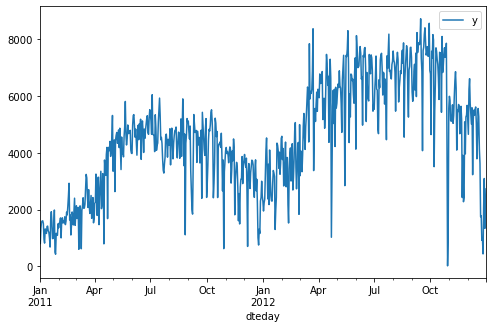

In [77]:
data['y'].plot(figsize=(8,5), legend=True)

# Seasonal Decomposition
- Basically split data into different groups (trends, seasonality and errors).
  - Trend - Most consistent line.
  - Seasonality - Somewhat consistent.
  - Error - Not consistent at all (no trend).

- Seasonality
  - Additive (absolute values)
  - Multiplicative (percentage values)

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

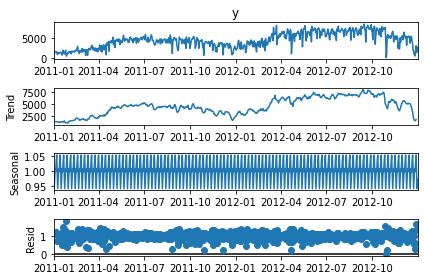

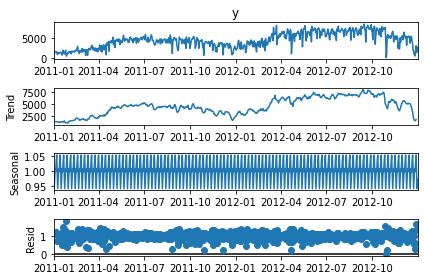

In [79]:
decomposition = seasonal_decompose(x=data.y, model='multiplicative')
decomposition.plot()

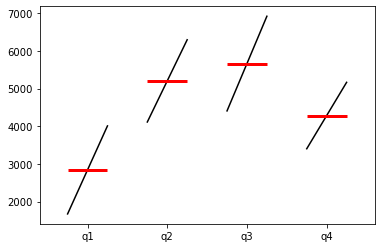

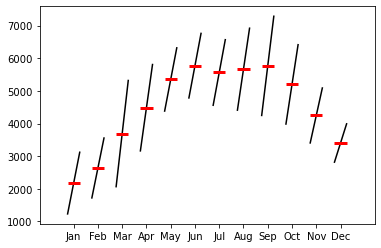

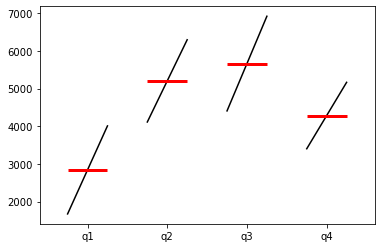

In [80]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(data.y.resample(rule='MS').mean())
quarter_plot(data.y.resample(rule='Q').mean())

# Holt-Winters (Tripple Exponential Smoothing)
A specialized exponential smoothing mechanism (Older data has less value).

Pros:
- Easy to apply
- Easy to understand

Cons:
- No support for external regressors
- Low flexibility
- Better with low amount of time periods or frequency

## Exponential Smoothing
- Split timeseries data into 3 sets.
  - Level
  - Trend
  - Seasonality
- Perform exponential smoothing on all of the above.
- Manually figure out if we're using additive or multiplicative mechanisms.

In [81]:
# Training & Test Sets
test_hours = 31
training_set = data.iloc[:-test_hours, :]
test_set = data.iloc[-test_hours:, :]

print(training_set.shape)
print(test_set.shape)

(700, 8)
(31, 8)


In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [83]:
# Forecasting model.
model = ExponentialSmoothing(
    endog=training_set.y, 
    trend='mul', 
    seasonal='mul').fit()

c:\ProgramData\miniforge3\envs\fbprophet\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [84]:
# Predictions.
predictions_hw = model.forecast(steps=len(test_set)).rename('HW')

<AxesSubplot:xlabel='dteday'>

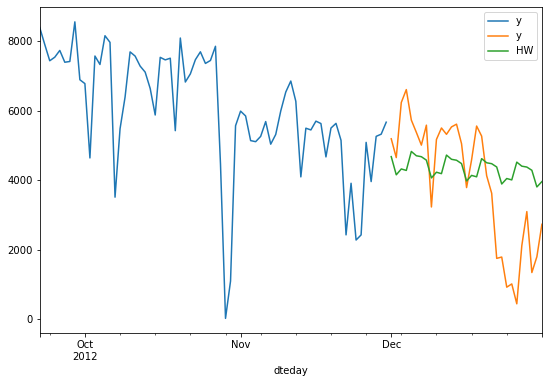

In [85]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_hw.plot(legend=True)

In [86]:
# Measurements
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [87]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [88]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_hw)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_hw))}')
print(f'MAPE: {mape(test_set.y, predictions_hw)}')

Mean Absolute Error: 1388.5193251096878
Mean Squared Error: 1697.6845363545444
MAPE: 87.26099293841784


In [89]:
# Export Forecasts
#predictions_hw.to_csv('predictions_hw.csv', index=True)

# TBATS
Similar but better than exponential smoothing.

- Trigonometrics seasonality
- Box-cox transformation
- AutoRegressive moving average
- Trend
- Seasonality

Pros:
- Seasonality allowed to change over time.
- Automated optimization.
- Easy implementation.

Cons:
- Prediction intervals often wide.
- Does not allow external regressors.
- Slow.

In [90]:
from tbats import TBATS

In [91]:
# Forecasting
model = TBATS(seasonal_periods = [7, 365.5])
model = model.fit(training_set.y)

In [92]:
# Predictions
predictions_tbats = pd.Series(model.forecast(steps=len(test_set))).rename('TBATS')
predictions_tbats.index = test_set.index

<AxesSubplot:xlabel='dteday'>

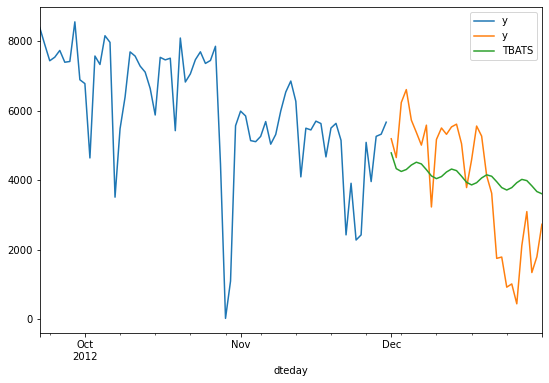

In [93]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_tbats.plot(legend=True)

In [94]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_tbats)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_tbats))}')
print(f'MAPE: {mape(test_set.y, predictions_tbats)}')

Mean Absolute Error: 1371.051177720764
Mean Squared Error: 1601.6653479244424
MAPE: 78.9307629961056


# ARIMA, SARIMA & SARIMAX
AutoRegressive integrated moving average, seasonal ARIMA and SARIMA + Exogenous variables.

Pros:
- Easy Implementation
- Auto Optimization
- Easy to Understand

Cons:
- Better for low amount of data.
- Low Flexibility

In [95]:
# Determine  Stationarity
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [96]:
stationarity = adfuller(data.y)

print(f'Augmented Dickey Fuller p-value: {stationarity[1]}')

Augmented Dickey Fuller p-value: 0.34274344033922044


In [97]:
training_set.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [98]:
# Exogenous Variables (External regressors - moving seasonality, events outside company control as well as company events)
train_exog = training_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]

In [99]:
model = auto_arima(
    y=training_set.y,
    x= train_exog,
    m=7,
    seasonal=True,
    stepwise=False # when theres tons of data to optimize through.
)

In [100]:
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  700
Model:             SARIMAX(0, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -5752.313
Date:                           Mon, 30 May 2022   AIC                          11518.625
Time:                                   17:15:49   BIC                          11550.473
Sample:                                        0   HQIC                         11530.937
                                           - 700                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8365      1.163      0.719      0.472      -1.442       3.115
ma.L1         -0.5843      0.027    -21.658      0.000      -0.637      -0.531
ma.L2         -0.2671      0.032     -8.259      0.000      -0.331      -0.204
ar.S.L7        0.8911      0.076     11.697      0.000       0.742       1.040
ma.S.L7       -0.9155      0.084    -10.964      0.000      -1.079      -0.752
ma.S.L14       0.0853      0.040      2.127      0.033       0.007       0.164
sigma2        8.3e+05   2.72e+04     30.545      0.000    7.77e+05    8.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1248.09
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               3.87   Skew:                            -1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
# Predictions
predictions_sarimax = pd.Series(model.predict(
    n_periods=test_hours,
    x=test_exog
)).rename('SARIMAX')
predictions_sarimax.index = test_set.index

predictions_sarimax.head()

dteday
2012-12-01    5243.642729
2012-12-02    4646.935258
2012-12-03    4472.727451
2012-12-04    4472.825141
2012-12-05    4787.763172
Freq: D, Name: SARIMAX, dtype: float64

<AxesSubplot:xlabel='dteday'>

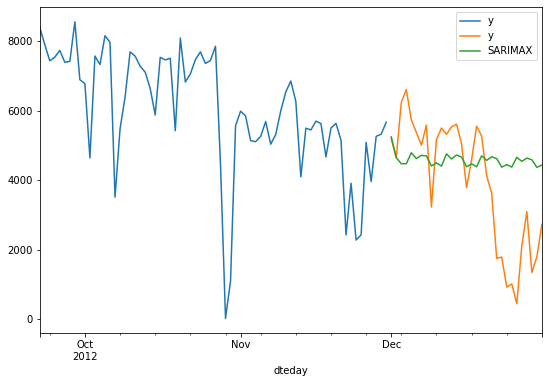

In [102]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_sarimax.plot(legend=True)

In [103]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_sarimax)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_sarimax))}')
print(f'MAPE: {mape(test_set.y, predictions_sarimax)}')

Mean Absolute Error: 1436.3961404700565
Mean Squared Error: 1825.1021109787437
MAPE: 94.07519968069764


# Facebook Prophet

In [104]:
import itertools
from fbprophet import Prophet

In [107]:
data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [108]:
# Load and prepare data.
data = pd.read_csv('./../../data/daily_bike_sharing.csv')
dataset = data.loc[:, ['dteday', 'cnt', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
dataset.dteday = pd.to_datetime(dataset.dteday, format = '%Y-%m-%d')
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})

In [109]:
# Holidays.
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({
    'holiday' : 'holi',
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': -3,
    'upper_window': 1
})
dataset = dataset.drop(columns='holiday')

In [110]:
# Training and test data sets.
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]

In [111]:
# Facebook Prophet model
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

In [112]:
# Create future dataframe.
future = m.make_future_dataframe(periods=len(test_set), freq='D')

In [113]:
# Merge regressors.
future = pd.concat([future, dataset.iloc[:,2:]], axis=1)

In [117]:
# Forecast.
forecast = m.predict(future)
predictions_prophet = forecast.yhat[-test_days:].rename('prophet')

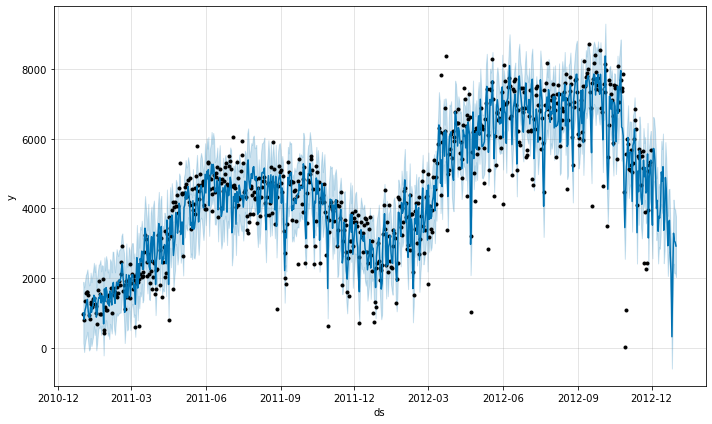

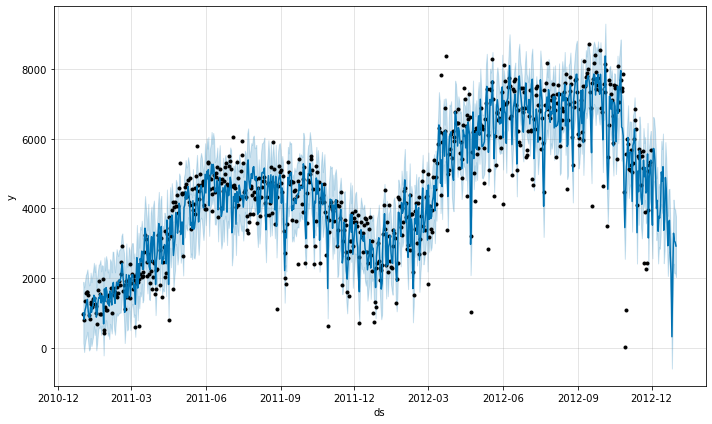

In [118]:
# Visualize.
m.plot(forecast)

c:\ProgramData\miniforge3\envs\fbprophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
c:\ProgramData\miniforge3\envs\fbprophet\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


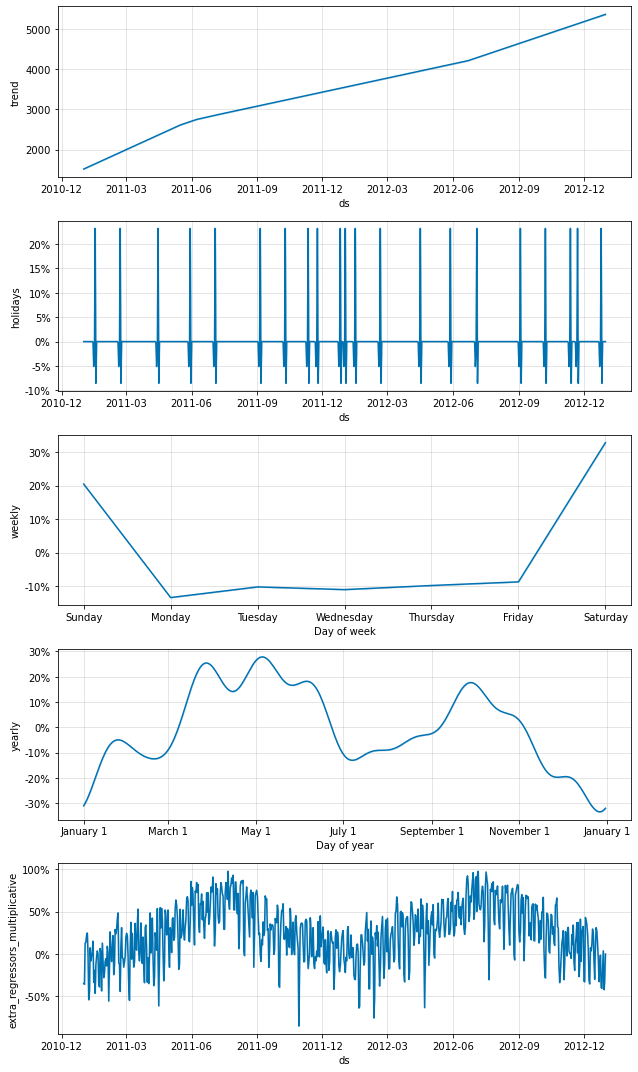

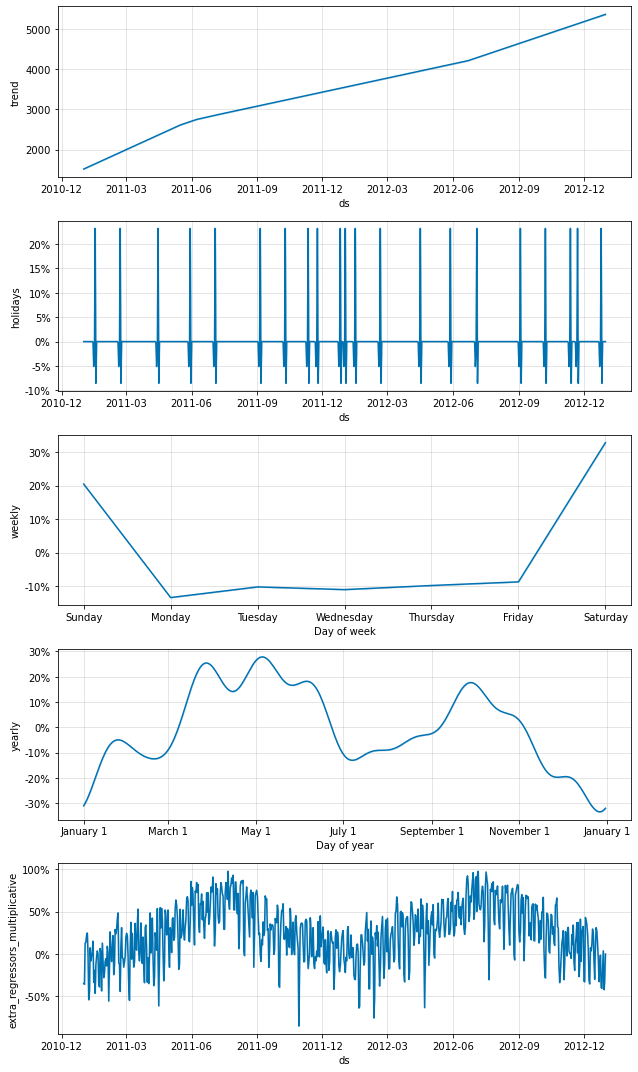

In [120]:
m.plot_components(forecast)

In [126]:
# Model Assessment.
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))
print(round(mape(test_set['y'], predictions_prophet), 0))

855.0
1024.0
34.0


In [127]:
# Cross validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m,
    horizon = '31 days',
    initial = '540 days',
    parallel = 'processes'
)
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001438C4BFEC8>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8183.187785,7475.398133,8955.203238,5463,2012-06-28
1,2012-06-30,7244.585250,6463.010874,7969.181976,5687,2012-06-28
2,2012-07-01,7448.095396,6653.775491,8268.488486,5531,2012-06-28
3,2012-07-02,6810.450716,6032.705937,7581.923982,6227,2012-06-28
4,2012-07-03,7454.800478,6743.258096,8256.948200,6660,2012-06-28


In [178]:
# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid

param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20]}
grid = ParameterGrid(param_grid)
list(grid)[:3]       

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [179]:
rmse = []
for params in grid:
    #build model
    m = Prophet(growth = 'linear',
                yearly_seasonality = True,
                weekly_seasonality = True,
                daily_seasonality = False,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale = params['seasonality_prior_scale'],
                holidays_prior_scale = params['holidays_prior_scale'],
                changepoint_prior_scale = params['changepoint_prior_scale'])
    m.add_regressor('workingday')
    m.add_regressor('weathersit')
    m.add_regressor('temp')
    m.add_regressor('atemp')
    m.add_regressor('hum')
    m.add_regressor('windspeed')
    m.fit(training_set)

    #cross-validation
    df_cv = cross_validation(m,
                            horizon = '31 days',
                            initial = '540 days',
                            parallel = 'processes')
    
    #gather the results
    error = np.sqrt(mean_squared_error(df_cv['y'], 
                                        df_cv['yhat']))
    rmse.append(error)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001438C4B6848>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000143D579D048>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000014388036148>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001438ED97FC8>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in pa

In [180]:
best_params = grid[np.argmin(rmse)]

print(best_params)

{'seasonality_prior_scale': 20, 'holidays_prior_scale': 20, 'changepoint_prior_scale': 0.01}


In [181]:
# Final Model.
m = Prophet(growth = 'linear',
          yearly_seasonality = True,
          weekly_seasonality = True,
          daily_seasonality = False,
          holidays = holidays,
          seasonality_mode = 'multiplicative',
          seasonality_prior_scale = best_params['seasonality_prior_scale'],
          holidays_prior_scale = best_params['holidays_prior_scale'],
          changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

In [182]:
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = 'D')
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)

In [183]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2429.697403,340.148063,2221.894381,2429.697403,2429.697403,-0.055504,-0.055504,-0.055504,-0.279367,...,0.000000,0.000000,0.000000,-0.261756,-0.261756,-0.261756,0.0,0.0,0.0,1256.422195
1,2011-01-02,2435.318939,25.857705,1924.729748,2435.318939,2435.318939,-0.060176,-0.060176,-0.060176,-0.288156,...,0.000000,0.000000,0.000000,-0.255684,-0.255684,-0.255684,0.0,0.0,0.0,1010.172963
2,2011-01-03,2440.940475,371.090492,2119.272691,2440.940475,2440.940475,-0.137832,-0.137832,-0.137832,-0.188024,...,0.033309,0.033309,0.033309,-0.248368,-0.248368,-0.248368,0.0,0.0,0.0,1312.999268
3,2011-01-04,2446.562011,488.570218,2407.391149,2446.562011,2446.562011,-0.127097,-0.127097,-0.127097,-0.177320,...,0.033309,0.033309,0.033309,-0.239920,-0.239920,-0.239920,0.0,0.0,0.0,1422.101654
4,2011-01-05,2452.183546,695.348459,2615.178556,2452.183546,2452.183546,-0.118994,-0.118994,-0.118994,-0.111639,...,0.033309,0.033309,0.033309,-0.230472,-0.230472,-0.230472,0.0,0.0,0.0,1599.565367


In [184]:
predictions_prophet_tuned = forecast.yhat[-test_days:].rename('prophet_tuned')
predictions_prophet_tuned.index = test_set['ds']
predictions_prophet_tuned.head()

ds
2012-12-01    4124.477760
2012-12-02    3496.954864
2012-12-03    5628.867553
2012-12-04    5610.252631
2012-12-05    5321.226902
Name: prophet_tuned, dtype: float64

# Facebook Prophet + XGBoost (Extreme Gradient Boosting)

## Import Libraries

In [187]:
import xgboost as xgb

## Prepare Data

In [189]:
prophet_variables = forecast.loc[:, ['trend', 'holi', 'weekly', 'yearly']]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2429.697403,0.0,0.058233,-0.261756
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2435.318939,0.0,-0.041359,-0.255684
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2440.940475,0.0,-0.025701,-0.248368
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2446.562011,0.0,-0.001495,-0.239920
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2452.183546,0.0,-0.005586,-0.230472


In [190]:
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846,6424.368084,0.0,-0.025701,-0.264297


In [192]:
# Isolate X and Y.
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [193]:
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

## XGBoost Model Setup

### Parameters

In [194]:
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

### Train the Model

In [195]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")],
                  verbose_eval = 15)

[0]	y-rmse:3891.58894
[15]	y-rmse:1607.49185
[30]	y-rmse:1368.36629
[45]	y-rmse:1290.71035
[60]	y-rmse:1257.12425
[75]	y-rmse:1205.51613
[90]	y-rmse:1184.79903
[99]	y-rmse:1174.05661


## Forecasting & Visualization

### Forecasting

In [197]:
predictions_xgb = pd.Series(model.predict(Test), name = 'XGBoost')
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    3996.192383
2012-12-02    3068.570312
Name: XGBoost, dtype: float32

### Setup Index

In [198]:
training_set.index = training_set.ds
test_set.index = test_set.ds

### Visualization

<AxesSubplot:xlabel='ds'>

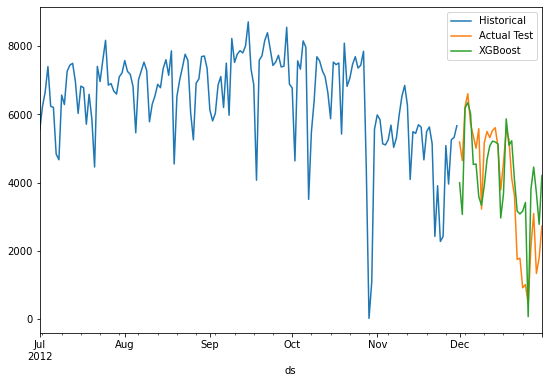

In [208]:
training_set.y['2012-07-01':].rename('Historical').plot(figsize = (9,6), legend = True)
test_set.y.rename('Actual Test').plot(legend = True)
predictions_xgb.plot(legend = True)

## Model Assessment

In [201]:
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))
print(round(mape(test_set['y'], predictions_xgb), 0))

946.0
1174.0
45.0
